In [1]:
import math
import numpy as np
from PIL import Image, ImageStat
import random
import matplotlib.pyplot as plt
from math import log2, sqrt

In [2]:
def m_map (xk, p):
    if xk<=0.5 and xk>=0:
        return ((xk/p)*(2-(xk/p)))
    elif xk<=1 and xk>0.5:
        return (((1-xk)/p)*(2-((1-xk)/p)))
    
def asymetric_tent_map(xk,p):
    if xk<p and xk>0:
        return (xk/p)
    elif xk<1 and xk>=p:
        return ((1-xk)/(1-p))
    
def to_hex(x):
    if x == 0:
        return [0, 0]
    hexa= []
    while x>0:
        check = x%16
        hexa.insert(0,check)
        x = x // 16
    if len(hexa)==0:
        hexa.append(0)
    elif len(hexa)==1:
        hexa.insert(0, 0)
    return hexa
#print(to_hex(255))

def to_decim(hexa):
    length = len(hexa) - 1
    dec = 0
    for digit in hexa:
        dec += digit*16**length
        length -= 1
    return dec

def encryption(im, x, p):
    ### CZYTANIE -> PERMUTACJA ###
    N,M = im.size
    print(im.size)
    im = np.asarray(im)
    #print(im)
    first_plc = []
    last_plc = []
    xk = x
    for i in range(len(im)):
        for j in range(len(im[i])):
            xk = m_map(xk,p)
            if xk <= 0.5:
                first_plc.append(im[i,j])
            elif xk > 0.5:
                last_plc.append(im[i,j])
                
    last_plc_rev = last_plc[::-1]
    first_plc.extend(last_plc_rev)
    
    Spx = np.sum(im)
    #first_plc = np.roll(first_plc, Spx) XDD
    
    px_list = []
    for i in range(M):
        px_list.append([])
        for j in range(N):
            px_list[i].append(first_plc[(i*M)+j])
    
    
    px = np.asarray(px_list)
    ### ZAPISYWANIE -> system szesnastkowy + dodawanie modulo ###
    ciphered_im = []
    xk = x
    print(len(px))
    print(xk)
    taba = []
    for i in range(len(px)):
        tmp_1 = []
        for j in range(len(px[i])):
            tmp_2 = []
            for k in range(len(px[i][j])):
                hexa = to_hex(px[i][j][k])
                #print(hexa)
                for a in range(len(hexa)):
                    xk = asymetric_tent_map(xk,p)
                    #print(xk)
                    xk_rounded = int(round(xk,3) * 100)
                    taba.append(xk_rounded)
                    hexa[a] = (hexa[a] + xk_rounded * Spx) % 16
                #print(hexa)
                tmp_2.append(to_decim(hexa))
                #print(tmp_2)
            tmp_1.append(tmp_2)       
        ciphered_im.append(tmp_1)
    ciphered_im = Image.fromarray(np.uint8(ciphered_im))
    
    return ciphered_im, Spx

def decryption(im, x, p, Spx):
    N,M = im.size
    print(im.size)
    px = np.asarray(im)
    xk = x
    decrypted_im = []
    taba = []
    for i in range(len(px)):
        tmp_1 = []
        for j in range(len(px[i])):
            tmp_2 = []
            for k in range(len(px[i][j])):
                hexa = to_hex(px[i][j][k])
                #print(hexa)
                for a in range(len(hexa)):
                    xk = asymetric_tent_map(xk,p)
                    #print(xk)
                    xk_rounded = int(round(xk,3) * 100 )
                    taba.append(xk_rounded)
                    hexa[a] = (hexa[a] - xk_rounded * Spx) % 16
                #print(hexa)
                tmp_2.append(to_decim(hexa))
                #print(tmp_2)
            tmp_1.append(tmp_2)       
        decrypted_im.append(tmp_1)
    decrypted_im = np.asarray(decrypted_im)
    print(decrypted_im.size)
    #px = []
    xk = x
    decrypted_im = decrypted_im.reshape(N*M,3)
    px_list = np.empty([len(decrypted_im), 3])
    i = 0
    while len(decrypted_im)>0:
        xk = m_map(xk,p)
        
        if xk <= 0.5: #pierwszy nieodczytany piksel
            px = decrypted_im[0]
            decrypted_im = np.delete(decrypted_im, 0, 0)
            px_list[i] = px
            
        elif xk > 0.5: #ostatni nieodczytany piksel
            px = decrypted_im[len(decrypted_im)-1]
            decrypted_im = np.delete(decrypted_im, len(decrypted_im)-1, 0)
            px_list[i] = px
        i=i+1  
    print(px_list)
    #px_list = np.roll(px_list, -Spx) XDxdDd
    decode_px = []
    for i in range(M):
        decode_px.append([])
        for j in range(N):
            decode_px[i].append(px_list[(i*M)+j])
    decode_px = Image.fromarray(np.uint8(decode_px))
    
    return decode_px
    

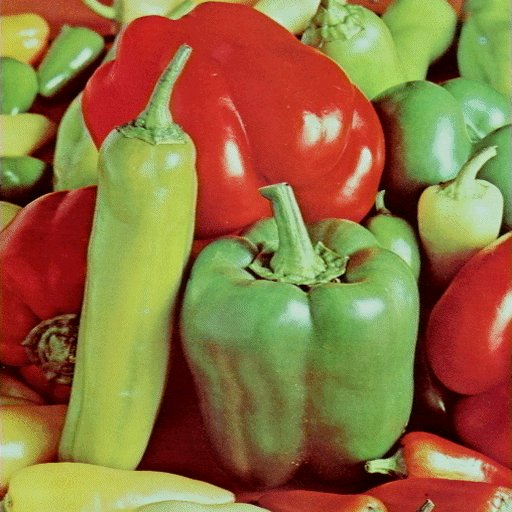

In [3]:
im = Image.open("pepers.jpg")
im

In [4]:
x = 0.354
p = 0.710
encrypted, Spx = encryption(im, x, p)

(512, 512)
512
0.354


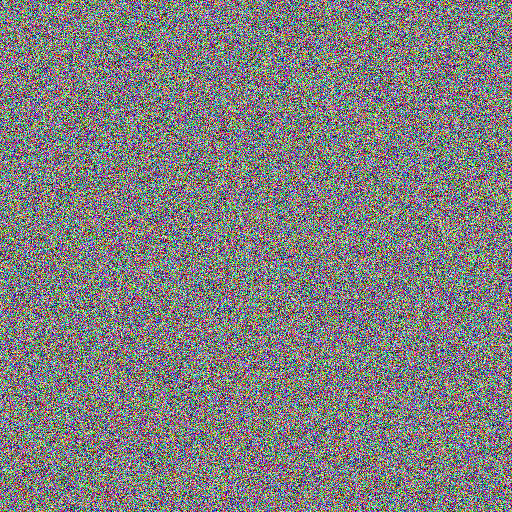

In [5]:
encrypted

(512, 512)
786432
[[178.  95.  65.]
 [177.  92.  61.]
 [173.  84.  52.]
 ...
 [175. 203. 165.]
 [178. 207. 163.]
 [181. 213. 166.]]


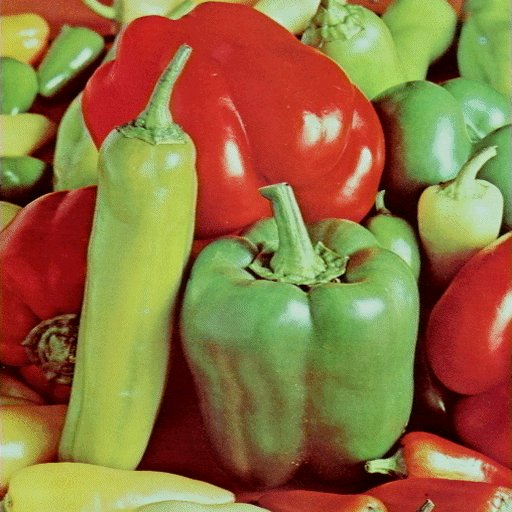

In [6]:
x = 0.354
p = 0.710
decrypted = decryption(encrypted, x, p, Spx)
decrypted  = Image.fromarray(np.uint8(decrypted))
decrypted

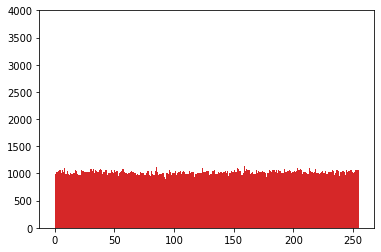

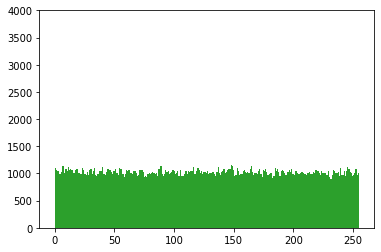

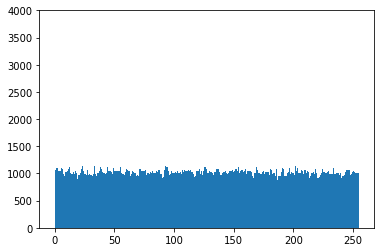

In [7]:
def draw_histograms(im): #rysowanie histogramów
    plt.hist([x[0] for x in list(im.getdata())], bins = 256, color = 'tab:red')
    plt.ylim((0,4000))
    plt.show()
    plt.hist([x[1] for x in list(im.getdata())], bins = 256, color = 'tab:green')
    plt.ylim((0,4000))
    plt.show()
    plt.hist([x[2] for x in list(im.getdata())], bins = 256, color = 'tab:blue')
    plt.ylim((0,4000))
    plt.show()
    
draw_histograms(encrypted)

In [8]:
im1 = im
N, M = im.size #szerokość, wysokość
im2 = im.copy()
im2_px = im2.load()
random_N = random.randint(0, N-1)
random_M = random.randint(0, M-1)
im2_px[random_N, random_M] = ((im2_px[random_N, random_M][0]+1)%256, (im2_px[random_N, random_M][1]+1)%256, (im2_px[random_N, random_M][2]+1)%256)
    
enc_im, tab = encryption(im1, x, p)
enc_im2, tab2 = encryption(im2, x, p)
    

(512, 512)
512
0.354
(512, 512)
512
0.354


In [9]:
def npcr2(im1, im2):
    im1 = np.asarray(im1)
    im2 = np.asarray(im2)
    values = [0,0,0]
    for i in range(len(im1)):
        for j in range(len(im1[i])):
            for k in range(len(im1[i][j])):
                if im1[i][j][k] != im2[i][j][k]:
                    values[k]+=1
    length = im1.size/3
    values = [(x/length) * 100 for x in values]
    return values

In [10]:
enc_im = Image.fromarray(np.uint8(enc_im))
enc_im2 = Image.fromarray(np.uint8(enc_im2))

npcr2(enc_im, enc_im2)

[99.30267333984375, 99.32212829589844, 99.31182861328125]

In [14]:
def npcr(im, x, p):
    N, M = im.size #szerokość, wysokość
    im2 = im.copy()
    im2_px = im2.load()
    random_N = random.randint(0, N-1)
    random_M = random.randint(0, M-1)
    im2_px[random_N, random_M] = ((im2_px[random_N, random_M][0]+1)%256, (im2_px[random_N, random_M][1]+1)%256, (im2_px[random_N, random_M][2]+1)%256)
    
    enc_im, a = encryption(im, x, p )
    enc_im2, v = encryption(im2, x, p)
    
    enc_px = list(enc_im.getdata())
    enc_px2 = list(enc_im2.getdata())
    
    res = []
    
    for i in range(0,3): #dla każdego kanału RGB
        dif_sum = 0 
        for j in range(len(enc_px)): #obliczenie sumy ze wzoru
            if enc_px[j][i] != enc_px2[j][i]:
                dif_sum += 1
        
        res.append(round((dif_sum/(N*M))*100,4))
        
    return res

In [15]:
im = Image.open("pepers.jpg")
npcr_res = npcr(im,x, p)

(512, 512)
512
0.354
(512, 512)
512
0.354


In [16]:
npcr_res

[99.3027, 99.3221, 99.3118]

In [17]:
def key_sensitivity(im, x, p, change_value):
    
    im_oryg, sp = encryption(im, x, p)
    im_x, sp = encryption(im, x+change_value, p)
    im_p, sp = encryption(im, x, p+change_value)
    
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.imshow(im_oryg)
    
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.imshow(im_x)
    
    plt.subplot(1,3,3)
    plt.axis('off')
    plt.imshow(im_p)

(512, 512)
512
0.354
(512, 512)
512
0.3540000000000001
(512, 512)
512
0.354


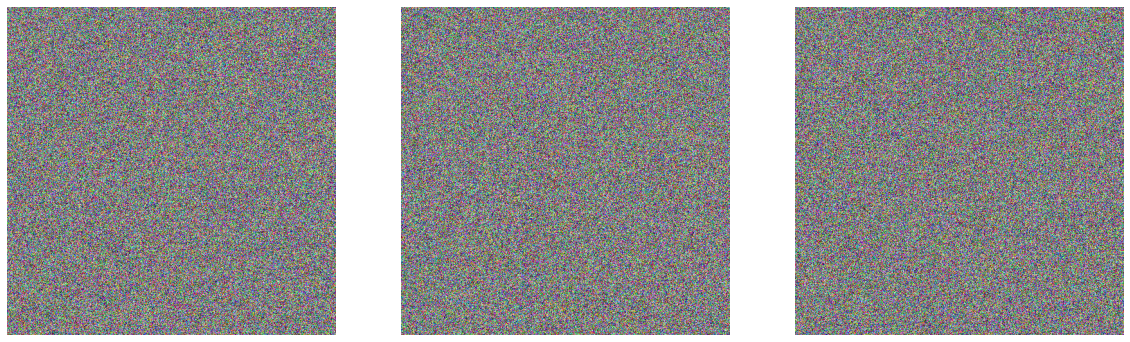

In [18]:
key_sensitivity(im, x, p, 10**(-16)) 

In [19]:
def uaci(im, x, p):
    N, M = im.size #szerokość, wysokość
    im2 = im.copy()
    im2_px = im2.load()
    random_N = random.randint(0, N-1)
    random_M = random.randint(0, M-1)
    im2_px[random_N, random_M] = ((im2_px[random_N, random_M][0]+1)%256, (im2_px[random_N, random_M][1]+1)%256, (im2_px[random_N, random_M][2]+1)%256)
    
    enc_im, sb = encryption(im, x, p)
    enc_im2, sb = encryption(im2, x, p)
    
    enc_px = list(enc_im.getdata())
    enc_px2 = list(enc_im2.getdata())
    
    res = []
    
    for i in range(0,3): #dla każdego kanału RGB
        dif_sum = 0 
        for j in range(len(enc_px)): #obliczenie sumy ze wzoru
            dif_sum += (abs(enc_px[j][i] - enc_px2[j][i])/255)
        
        res.append(round((dif_sum/(N*M))*100,2))
    return res

In [20]:
uaci_res = uaci(im, x, p)

(512, 512)
512
0.354
(512, 512)
512
0.354


In [21]:
uaci_res

[34.2, 33.18, 33.63]

In [22]:
def correlations(im, x, p, encrypted = 1):
    
    if encrypted == 1:
        im, sp = encryption(im, x, p)
    
    N, M = im.size
    r = []
        
    #horizontal
    im21 = im.crop((0,0,N-1,M))
    im22 = im.crop((1,0,N,M))
    
    stat21 = ImageStat.Stat(im21)
    stat22 = ImageStat.Stat(im22)
    stat21_mean = stat21.mean
    stat22_mean = stat22.mean
    
    im21_px = im21.load()
    im22_px = im22.load()
    
    r_temp = []
    for k in range(3):
        cov = 0
        var21 = 0
        var22 = 0
        for i in range(M):
            for j in range(N-1):
                var21 += (im21_px[j,i][k] - stat21_mean[k])**2
                var22 += (im22_px[j,i][k] - stat22_mean[k])**2
                cov += (im21_px[j,i][k] - stat21_mean[k])*(im22_px[j,i][k] - stat22_mean[k])
                
        cov = cov/N
        sigma21 = sqrt(var21/N)
        sigma22 = sqrt(var22/N)
        r_value = cov/(sigma21*sigma22)
        r_temp.append(round(r_value,4))
    r.append(r_temp)
    
    #vertical
    im31 = im.crop((0,0,N,M-1))
    im32 = im.crop((0,1,N,M))
    
    stat31 = ImageStat.Stat(im31)
    stat32 = ImageStat.Stat(im32)
    stat31_mean = stat31.mean
    stat32_mean = stat32.mean
    
    im31_px = im31.load()
    im32_px = im32.load()
    
    r_temp = []
    for k in range(3):
        cov = 0
        var31 = 0
        var32 = 0
        for i in range(M-1):
            for j in range(N):
                var31 += (im31_px[j,i][k] - stat31_mean[k])**2
                var32 += (im32_px[j,i][k] - stat32_mean[k])**2
                cov += (im31_px[j,i][k] - stat31_mean[k])*(im32_px[j,i][k] - stat32_mean[k])
                
        cov = cov/N
        sigma31 = sqrt(var31/N)
        sigma32 = sqrt(var32/N)
        r_value = cov/(sigma31*sigma32)
        r_temp.append(round(r_value,4))
    r.append(r_temp)
    
    #diagonal
    im41 = im.crop((0,0,N-1,M-1))
    im42 = im.crop((1,1,N,M))
    
    stat41 = ImageStat.Stat(im41)
    stat42 = ImageStat.Stat(im42)
    stat41_mean = stat41.mean
    stat42_mean = stat42.mean
    
    im41_px = im41.load()
    im42_px = im42.load()
    
    r_temp = []
    for k in range(3):
        cov = 0
        var41 = 0
        var42 = 0
        for i in range(M-1):
            for j in range(N-1):
                var41 += (im41_px[j,i][k] - stat41_mean[k])**2
                var42 += (im42_px[j,i][k] - stat42_mean[k])**2
                cov += (im41_px[j,i][k] - stat41_mean[k])*(im42_px[j,i][k] - stat42_mean[k])
                
        cov = cov/N
        sigma41 = sqrt(var41/N)
        sigma42 = sqrt(var42/N)
        r_value = cov/(sigma41*sigma42)
        r_temp.append(round(r_value,4))
    r.append(r_temp)
      
    return r

In [23]:
r = correlations(im, x, p, 1)

(512, 512)
512
0.354


In [ ]:
r